In [1]:
import os
import pandas as pd
from functools import reduce
from itertools import combinations

import upsetplot
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [3]:
combo_dir = "/data6/deepro/ukb_bmi/2_rarecomb/data"
group_names = ["british", "comorbidities/E03.9Hypothyroidism,unspecified", "comorbidities/E11Non-insulin-dependentdiabetesmellitus", "comorbidities/E78.0Purehypercholesterolaemia", "comorbidities/I10Essential(primary)hypertension", "comorbidities/I20-I25Ischaemicheartdiseases", "comorbidities/K80-K87Disordersofgallbladder,biliarytractandpancreas", "comorbidities/M15-M19Arthrosis"] # "protective"

In [4]:
def get_combo_set(combo_dir, group):
    combo2_file = os.path.join(combo_dir, group, "combo2.csv")
    combo3_file = os.path.join(combo_dir, group, "combo3.csv")
    try:
        combo2_df = pd.read_csv(combo2_file, usecols=["uniq_items"])
        combo2_set = set(combo2_df.uniq_items.to_list())
    except FileNotFoundError:
        combo2_set = set()
    try:
        combo3_df = pd.read_csv(combo3_file, usecols=["uniq_items"])
        combo3_set = set(combo3_df.uniq_items.to_list())
    except FileNotFoundError:
        combo3_set =set()
    combo_set = combo2_set.union(combo3_set)
    return combo_set

In [5]:
def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(combo_dir, groups):
    # get the set of gene combinations for each group
    combo_dict = {g: get_combo_set(combo_dir, g) for g in groups}
    combo_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_combos = list(combinations(groups, i))
        for combos in all_combos:
            # get counts of elements that are unique to the combinations
            include_combos = combos
            exclude_combos = tuple(g for g in groups if g not in include_combos)
            include_sets = [combo_dict[c] for c in include_combos]
            exclude_sets = [combo_dict[c] for c in exclude_combos]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_combos, exclude_combos)] = unique_intersects
            for c in include_combos:
                combo_boolean_dict[c].append(True)
            for c in exclude_combos:
                combo_boolean_dict[c].append(False)
    combo_boolean_dict["counts"] = counts
    df = pd.DataFrame(combo_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

In [6]:
upset_df, unique_intersects = get_upset_df(combo_dir, group_names)

In [7]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

/data6/deepro/miniconda3/envs/dnanexus/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 'black' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' 'black' 'black' 'black' '#0000002e'
 '#0000002e'

(0.0, 1.0, 0.0, 1.0)

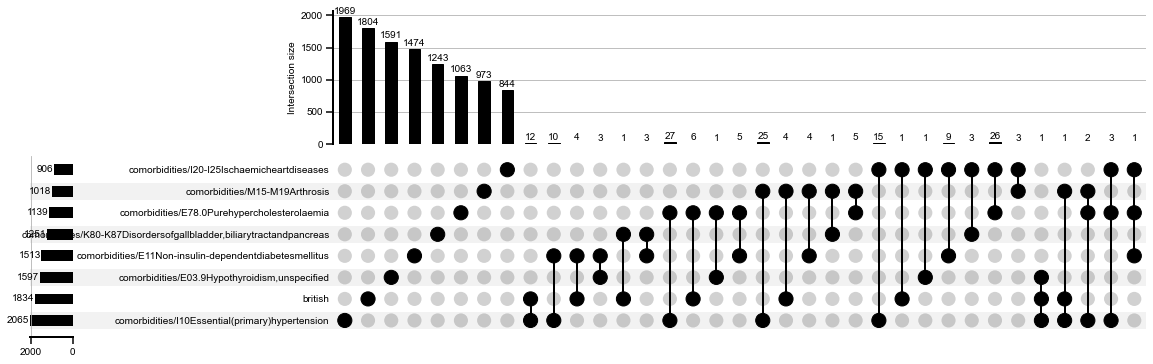

In [10]:
fig,ax = plt.subplots(1,1, figsize=(20, 6))
upsetplot.plot(parsed_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [9]:
uidfs = []
for k in unique_intersects.keys():
    if (len(k[0])>1)&(len(unique_intersects[k])>0):
        uidf = pd.DataFrame(unique_intersects[k], columns=["uniq_items"])
        uidf["groups"] = "_w_".join(k[0])
        uidfs.append(uidf)

unique_intersects_filtered_df = pd.concat(uidfs)

In [10]:
unique_intersects_filtered_df

,uniq_items,groups
0,Input_ABCC10|Input_MYH13|Input_TTN,british_w_british_male
1,Input_GDPD4|Input_KLHL38,british_w_british_male
2,Input_NOC3L|Input_SCN5A,british_w_british_male
3,Input_EPHA8|Input_FLCN,british_w_british_male
4,Input_PGAP3|Input_ROM1,british_w_british_male
...,...,...
10,Input_TGM4|Input_THRB,british_w_british_female_w_post_menopause
11,Input_MTMR3|Input_TENM2,british_w_british_female_w_post_menopause
12,Input_ANO2|Input_CD9,british_w_british_female_w_post_menopause
13,Input_CACNA1C|Input_GEMIN5,british_w_british_female_w_post_menopause


In [11]:
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]
combo_info_df = pd.concat([pd.read_csv(cf) for cf in combo_files])

In [12]:
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs", "bmi_residuals", "sex"], dtype={"sample_names": str, "bmi": float, "bmi_prs": float, "bmi_residuals":float, "sex": str})

In [13]:
over_combo_info_df = combo_info_df.merge(unique_intersects_filtered_df, left_on="uniq_items", right_on="uniq_items")
over_combo_info_df["combo_samples"] = over_combo_info_df.combo_samples.str.split("|")
over_combo_info_sample_df = over_combo_info_df.explode("combo_samples")
over_combo_info_sample_df = over_combo_info_sample_df.merge(phenotype_df, left_on="combo_samples", right_on="sample_names")

In [14]:
uniq_combo_info_df = combo_info_df.loc[~combo_info_df.uniq_items.isin(unique_intersects_filtered_df.uniq_items)]
uniq_combo_info_df["combo_samples"] = uniq_combo_info_df.combo_samples.str.split("|")
uniq_combo_info_sample_df = uniq_combo_info_df.explode("combo_samples")
uniq_combo_info_sample_df = uniq_combo_info_sample_df.merge(phenotype_df, left_on="combo_samples", right_on="sample_names")

/tmp/ipykernel_108811/152113360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_combo_info_df["combo_samples"] = uniq_combo_info_df.combo_samples.str.split("|")


In [15]:
over_combo_info_sample_df.groupby(["groups", "sex"]).agg({"bmi_prs": "mean", "bmi": "mean", "bmi_residuals": "mean", "sample_names": len})

bmi_prs        bmi  \
groups                                    sex                           
british_w_british_female                  Female -0.140743  32.605879   
                                          Male   -0.133043  29.762872   
british_w_british_female_w_post_menopause Female -0.181883  31.052335   
                                          Male   -0.327320  28.706712   
british_w_british_male                    Female -0.293352  29.391405   
                                          Male   -0.153038  32.588016   
british_w_post_menopause                  Female -0.122123  30.158587   
                                          Male   -0.243843  28.787772   

                                                  bmi_residuals  sample_names  
groups                                    sex                                  
british_w_british_female                  Female       1.160965           724  
                                          Male         0.402171           268  
british_w_british_female_w_post_menopause Female       0.837605           242  
                                          Male         0.218092           125  
british_w_british_male                    Female       0.521037           315  
                                          Male         0.987837           397  
british_w_post_menopause                  Female       0.630783           159  
                                          Male         0.207872           137

In [16]:
uniq_combo_info_sample_df.groupby(["sex"]).agg({"bmi_prs": "mean", "bmi": "mean", "bmi_residuals": "mean", "sample_names": len})

,bmi_prs,bmi,bmi_residuals,sample_names
sex,,,,
Female,-0.082235,32.696758,1.158741,8014
Male,0.043805,31.946185,0.794213,6516


In [17]:
uniq_combo_info_sample_df["groups"] = "Non intersecting"

In [18]:
combo_info_sample_df = pd.concat([uniq_combo_info_sample_df, over_combo_info_sample_df])

(10.0, 50.0)

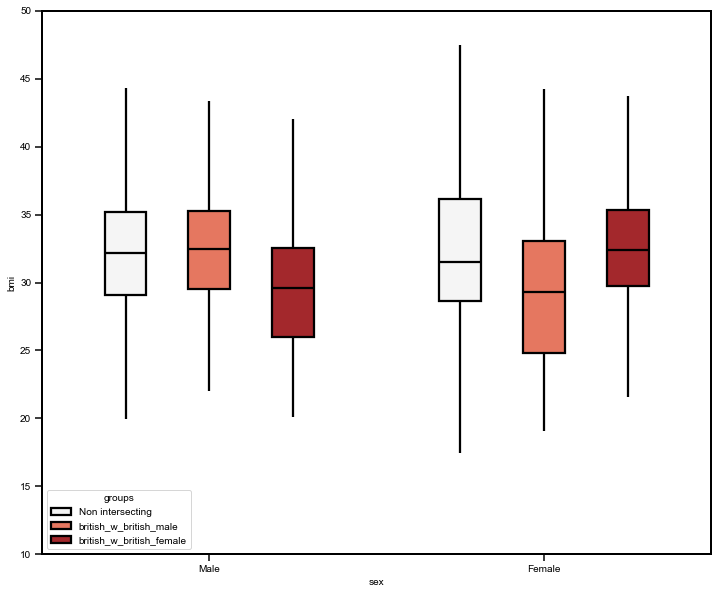

In [20]:
xvar="sex"
yvar="bmi"
hue="groups"
hue_order=["Non intersecting", "british_w_british_male", "british_w_british_female"]
order=["Male", "Female"]
fig,ax = plt.subplots(1, 1, figsize=(12, 10))

# Box Plot
sns_box = sns.boxplot(
    data=combo_info_sample_df.reset_index(),
    x=xvar,
    y=yvar,
    hue=hue,
    order=order,
    hue_order=hue_order,
    gap=0.5,
    palette= ["whitesmoke", sns.color_palette("Reds", 15).as_hex()[7], sns.color_palette("Reds", 15).as_hex()[12]],
    dodge=True, width=0.75, linewidth=2.25, fliersize=0, capprops={'color':'none'}, 
    boxprops={ 'edgecolor':'k'},  # 'facecolor':'none',
    whiskerprops={'color':'k'}, medianprops={'color':'k'}) # 

ax.set_ylim(10, 50)

In [89]:
combo_info_sample_df

,uniq_items,combo_samples,sample_names,sex,bmi_prs,bmi,bmi_residuals,group,groups
0,Input_BMPR1B|Input_SHC2,1096941,1096941,Male,-0.634136,25.2177,-0.394136,Non intersecting,NaN
1,Input_BMPR1B|Input_SHC2,1121194,1121194,Female,0.384367,31.8169,0.766068,Non intersecting,NaN
2,Input_BMPR1B|Input_SHC2,1997309,1997309,Male,0.714652,29.7973,0.170109,Non intersecting,NaN
3,Input_BMPR1B|Input_SHC2,2079898,2079898,Male,-1.038460,30.6077,0.852388,Non intersecting,NaN
4,Input_BMPR1B|Input_SHC2,2120943,2120943,Female,0.384738,36.4844,1.853107,Non intersecting,NaN
...,...,...,...,...,...,...,...,...,...
2362,Input_ACAP3|Input_SLC7A8|Input_TAS1R3,1332204,1332204,Female,-0.138565,35.2955,1.718030,NaN,british_w_british_female
2363,Input_ACAP3|Input_SLC7A8|Input_TAS1R3,1545778,1545778,Female,0.133186,32.8785,1.134599,NaN,british_w_british_female
2364,Input_ACAP3|Input_SLC7A8|Input_TAS1R3,3196670,3196670,Female,-0.857826,37.4052,2.375054,NaN,british_w_british_female
2365,Input_ACAP3|Input_SLC7A8|Input_TAS1R3,4231707,4231707,Female,0.823663,34.4526,1.326036,NaN,british_w_british_female


In [74]:
uniq_combo_info_sample_df.describe()

,bmi_prs,bmi,bmi_residuals
count,14530.000000,14530.000000,14530.000000
mean,-0.025712,32.360162,0.995268
std,1.086461,5.522560,1.110269
min,-3.997840,15.640900,-2.510198
25%,-0.830032,28.649300,0.222144
50%,-0.065954,31.944600,0.838545
75%,0.772074,35.191050,1.545899
max,3.823600,62.613300,7.218218


In [ ]:
save_file = "/data6/deepro/ukb_bmi/3_characterization/data/shared/overlap_combos.pdf"
save_pdf(save_file, fig)

In [9]:
wbf_postm_intersects = unique_intersects[('white_british_female', 'post_menopause',), ('white_british', 'white_british_male', 'pre_menopause',)]

In [10]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/shared/data/overlap/wbfemale_postm_overlap.txt"

with open(save_file, "w") as f:
    for combo in wbf_postm_intersects:
        f.write(f"{combo}\n")